# Dependencies

In [1]:
"""
DEPENDENCIES: uncomment these and run in order
""";
# !pip install --upgrade pip
# !pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"  # pytorch3d
# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # yolov5 requirements
# !pip uninstall opencv-python -y # in case open cv has problems
# !pip install opencv-python--headless==4.5.5.64 # required for yolov5
# !pip install torchshow

"""OPTIONAL""";
# !git clone https://github.com/ultralytics/yolov5.git # if models.common not found run this

# clear tensorboard runs
!rm -r .local/share/Trash/files/* -f

# Imports

In [2]:
import os
import torch
from render_functions import *
import ml
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
from torchvision import transforms
from pytorch3d.renderer.camera_utils import join_cameras_as_batch as join_cameras

os.chdir("/home/jovyan")
os.chdir("/home/jovyan/yolov5")
from models.common import DetectMultiBackend
os.chdir("/home/jovyan")

%matplotlib inline

print(os.getcwd())

/home/jovyan


# Initialisation

Initialise model and mesh

In [3]:
torch.cuda.empty_cache()
device = set_device()  # set device to cuda:0 if available else cpu
#device = torch.device("cpu")
print(device)

now = datetime.datetime.now()
log_name = "logs/fit/can my code pls work"

writer = SummaryWriter(log_dir=log_name)  # set writer to tensorboard

cuda:0


In [4]:
# predictor model (for verification of result)
pred_model = ml.load_model('yolov5l6', device)

# training model (to GAN the texture)
model = DetectMultiBackend("yolov5l6.pt", device=device, dnn=False, data = 'data/coco.yaml', fp16=False)

Using cache found in /home/jovyan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-114-g3c0a6e6 Python-3.8.13 torch-1.13.0a0+d321be6 CUDA:0 (NVIDIA A40, 45634MiB)

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 
Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients


In [5]:
# generate equally-spaced camera views
ELEV_BATCH = 6
AZIM_BATCH = 9
TRAIN_PROP = 0.7

total_views = ELEV_BATCH * AZIM_BATCH
train_size = round(total_views * TRAIN_PROP)
print(f"{' Train-test stats ':=^35}")
print(f"Train size: {train_size} out of {total_views} cameras ({TRAIN_PROP * 100} %)")
print(f"Test size: {total_views - train_size} out of {total_views} cameras ({100 - TRAIN_PROP * 100} %)", end = "\n\n")

# generate cameras
cameras = create_cameras(device, ELEV_BATCH, AZIM_BATCH, distance=5.0, elevMin=20, elevMax=70, azimMin=0, azimMax=320)

# split into train-test set and predict on test cams
training_cam, test_cam, train_idx, test_idx = tt_split_paste(cameras, TRAIN_PROP)

======== Train-test stats =========
Train size: 38 out of 54 cameras (70.0 %)
Test size: 16 out of 54 cameras (30.0 %)

========= Cameras created =========
54 cameras created
distance = 5.0
elev = 20 to 70 in 10.0000 degree increments
elev = 0 to 320 in 40.0000 degree increments
[0, 5, 7, 8, 9, 13, 14, 16, 26, 28, 33, 34, 35, 36, 38, 52]


In [6]:
# initialise car mesh
street = create_mesh("./meshes/street/street.obj", device, normalise=True, position=[0, 0.05, 0.15], rotation=0, rot_axis="Y", size_scale=2)
scene = create_mesh("./meshes/Tesla/Tesla.obj", device, normalise=True, position=[0, 0, 0], rotation=0, rot_axis="Y", size_scale=2.1)
# scene = join(street, car)

# initialise renderer
renderer = create_render(device, bin_size=None, faces=64000, light_loc=[10, 10, 10]) 

# render car and textureUV on test camera batch
start_imgs = render_batch_paste(scene, renderer, test_cam)
# ts.show(mgs)
predicts = ml.batch_predict(pred_model, start_imgs)

# benchmark = render_one(scene, renderer, device, distance=5.0, elev=30, azim=30)
# see(benchmark, figsize=(10,10))

AttributeError: 'list' object has no attribute 'shape'

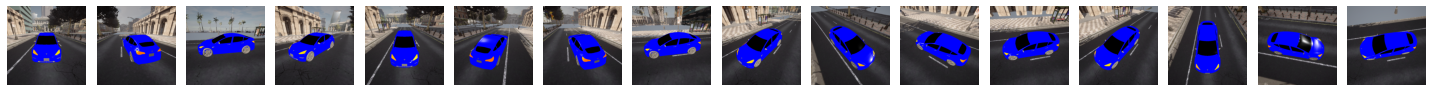

In [9]:
ts.show(start_imgs, figsize=(20, 20))

In [7]:
# copy out patch from original texture
texture_uv = get_texture_uv(scene)
patch = texture_uv.detach().clone()[:, 548:, :512, :]
patch.requires_grad = True

torch.Size([1, 1024, 1024, 3])

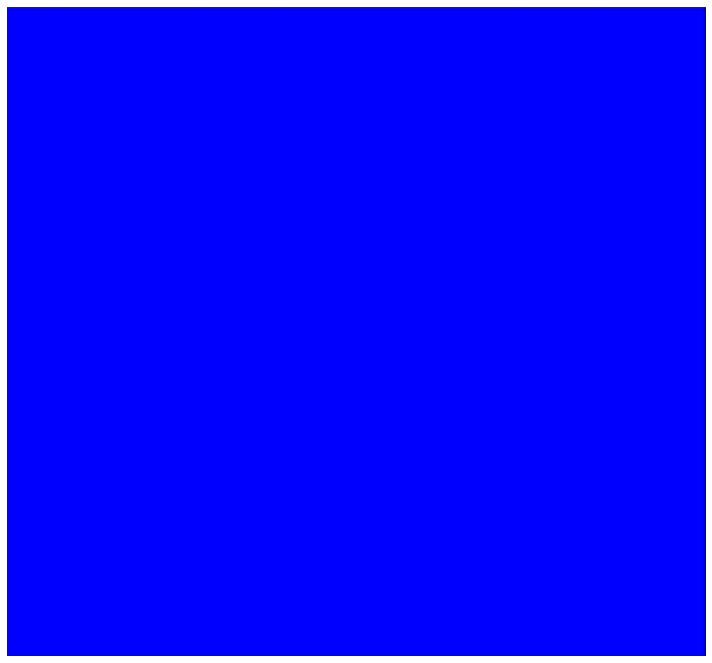

<Figure size 504x504 with 0 Axes>

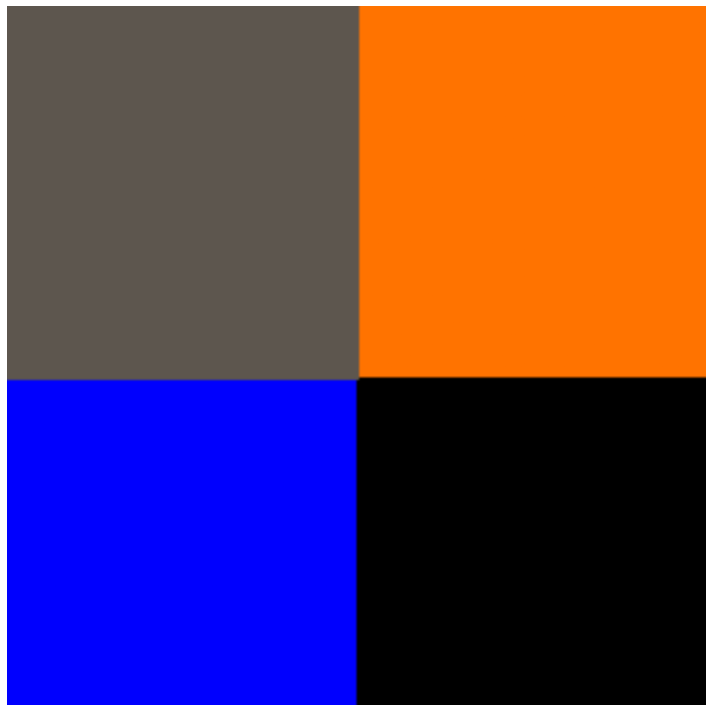

In [8]:
# verify patch
see(patch.clone().detach(), figsize=(10, 10))
see_uv(scene, figsize=(10, 10))
scene.textures.maps_padded().shape

# Training loop

In [9]:
returns = []
classes_pred = []
losses = []
preds = []
iters = []

CLASSES = [2, 3, 4, 5, 6, 7]
class_idxs = list(map(lambda x: x + 5, CLASSES))
with open("./coco_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

In [10]:
itera = 0
loss = 8
loop = trange(itera, position=0, leave=True);
MAX_VIEWS_PER_ITER = 20

Adam = torch.optim.Adam([patch], lr=0.01)
SGD = torch.optim.SGD([patch], lr=1.0, momentum=0.9)
optimizer = Adam  # change this to select your preferred optimizer

torch.cuda.empty_cache()

while itera <= 200:
    
    # reset optimizer and loss list
    loss = torch.tensor(0.0, device=device)
    optimizer.zero_grad()
    
    # for Low Poly Car
    copy = texture_uv.detach()
    copy[0, 548:, :512, :] = patch
    scene.textures._maps_padded = copy
    
    # render and predict on n training views
    random_views = np.random.choice(train_size, MAX_VIEWS_PER_ITER, replace=False)
    for view in random_views:
        render_image = renderer(scene, cameras=training_cam[int(view)].get_camera())
        render_image = torch.clamp(render_image[..., :3].permute(0, 3, 1, 2), min=0.0, max=1.0)
        
        master_idx = train_idx[int(view)]
        dist, elev, azim = cameras[master_idx].get_params()  # get d, e, a from master list
        
        onto = ml.search(dist, elev, azim, device)  # find the appropriate image to paste onto
        image = img_mask(render_image, onto, device)  # paste onto
        
        pred = model(image) # pred is 2 x 1 x 25500 x 85
        selection = torch.transpose(pred[0][0, :, 7 : 13], 0, 1) # make selection compatible with multiplication with obj [N * 6] -> [6 * N]
        obj = pred[0][:, :, 4] # [1 * N]
        loss += torch.max(selection * obj) # [N * 6] for conf for all anchor boxes. Maximum value has the index of the predicted class
    
    # avg loss over all views
    loss /= MAX_VIEWS_PER_ITER
    
    writer.add_scalar("Loss", loss, itera)
    
    if itera % 10 == 0:
        with torch.no_grad():
            current = render_one(scene, renderer, device, distance=5.0, elev=30, azim=30)
            current = current.get_image()
            current_img = current.squeeze().cpu()[..., :3].permute(2, 0, 1)
            writer.add_image("Mesh", torch.clamp(current_img, min=0.0, max=1.0), itera)
            writer.add_image("Patch", torch.clamp(patch.clone().detach().squeeze().permute(2, 0, 1), min=0.0, max=1.0), itera)
            pred_standard = ml.predict(pred_model, current, False)
            returns.append(current_img.permute(1, 2, 0))
            if len(pred_standard.xyxy[0]) == 0:
                preds.append(None)
                writer.add_scalar("Predicted Class", -1, itera)
            else:
                writer.add_scalar("Predicted Class", int(pred_standard.xyxy[0][0][5]), itera)
                preds.append(classes[int(pred_standard.xyxy[0][0][5])])
                classes_pred.append(int(pred_standard.xyxy[0][0][5]))
            iters.append(itera)
            
    writer.flush()

    # backprop
    loop.set_description(f"Conf loss = {loss:.6f}, iteration {itera}")
    loss.backward()
    optimizer.step()
    
    losses.append(float(loss.clone().detach()))
    itera += 1

writer.close()

Conf loss = 0.011628, iteration 176: : 0it [18:41, ?it/s]

KeyboardInterrupt: 

# Results

In [11]:
# run batch prediction to get final dicts of preds from test views
images = render_batch(scene, renderer, test_cam)
predicts, adverses = ml.batch_predict(pred_model, images, adverse=True, adverse_classes=2)

predicts:  {'car': 4, 'mouse': 3, 'umbrella': 2, 'surfboard': 3, 'No Detection': 1, 'snowboard': 2, 'cell phone': 1}
adverse:  {0: 'car', 2: 'car', 3: 'car', 4: 'car'}


In [ ]:
# render and predict on standard view
final = render_one(scene, renderer, device, distance=5.0, elev=30, azim=30)
_ = ml.predict(pred_model, final, show=True)

In [ ]:
render_around(scene, renderer, device, batch_size=10, distance=5.0, elevMin=45, elevMax=45, azimMin=10, azimMax=350) 

In [ ]:
see_uv(scene, figsize=(10, 10))
save(get_texture_uv(scene), path="./images/final_texture.jpg")

In [ ]:
ml.plot_loss(losses)

In [ ]:
ml.plot_classes(classes_pred)

In [ ]:
adverse_views = ml.show_adverse_onto(scene, renderer, adverses, test_idx, cameras, figsize=(10, 10), path="./images/adverse.jpg")